## 1. Function

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_matrix(M, type="seaborn"):
    if type == "seaborn":
        sns.heatmap(M, linewidth=0.5)
    else:
        plt.imshow(M, cmap='viridis')
        plt.colorbar()
        plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [21]:
import numpy as np
import ot
def cost_matrix(x, y):
    x = np.array(x).reshape(np.array(x).shape[0], -1)
    y = np.array(y).reshape(np.array(y).shape[0], -1)
    C = ot.dist(x, y, metric='euclidean', p=2)
    return C

In [22]:
def create_mask_linear(xs, xt, lamb):
    n = len(xs)
    m = len(xt)
    M = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if (i > j*n/m - lamb) & (i < j*n/m + lamb):
                M[i][j] = 1
    return M

In [23]:
import math
import numpy as np
def create_neighbor_relationship(x):
    xs = np.array(x).reshape(np.array(x).shape[0], -1)
    xt = np.concatenate((np.array([np.zeros_like(xs[0])]),xs ), axis=0)[:-1]
    f = xs - xt
    d = np.linalg.norm(f, axis=1)
    f1 = np.cumsum(d)
    sum_dist = f1[len(f1)-1]
    return f1/sum_dist

def create_mask_KL(xs, xt, sigma=1, type=1):
    f1 = create_neighbor_relationship(xs)
    f2 = create_neighbor_relationship(xt)
    n = len(f1)
    m = len(f2)
    mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
    M = np.abs(np.subtract.outer(f1, f2)) / mid_para
    return np.exp(-(np.power(M, 2)) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))

def create_mask_non_linear(xs, xt, ratio=0.1, sigma=1, type=1):
    f1 = create_neighbor_relationship(xs)
    f2 = create_neighbor_relationship(xt)
    n = len(f1)
    m = len(f2)
    mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
    KL = np.abs(np.subtract.outer(f1, f2)) / mid_para
    KL = np.exp(-(np.power(KL, 2)) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))
    flattened_list = KL.flatten()
    sorted_list = sorted(flattened_list)
    pivot = sorted_list[math.floor((1-ratio)*len(sorted_list))]
    M = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if KL[i][j] > pivot:
                M[i][j] = 1
    return M

In [24]:
import numpy as np
import cvxpy as cvx
import scipy.optimize._linprog as linprog
import scipy.sparse as sps
def lp(p, q, C, Mask=None,sparse=True):
    c = np.reshape(C.T,(-1,1))
    b = np.vstack((p.reshape(-1,1),q.reshape(-1,1)))
    if not sparse:
        A = np.vstack((np.kron(np.ones((1,len(q))),np.eye(len(p))),
                       np.kron(np.eye(len(q)),np.ones((1,len(p))))
                       ))
    else:
        A = sps.vstack((sps.kron(np.ones((1,len(q))),sps.eye(len(p))),
                       sps.kron(sps.eye(len(q)),np.ones((1,len(p))))
                       ))
    if Mask is not None:
        m = np.reshape(Mask.T,(-1,1))
        if not sparse:
            A = A*(m.T)
        else:
            A = A @ sps.diags(np.reshape(m, (-1,)))
        c = c*m
    x = cvx.Variable((len(c),1))
    cons = [x>=0,
            A@x==b]
    obj = cvx.Minimize(c.T@x)
    prob = cvx.Problem(obj,cons)
    prob.solve()

    # print(prob.status)
    pi = x.value
    pi = np.reshape(pi,(len(q),len(p)))
    pi = pi.T
    if Mask is not None:
        pi = pi*Mask
    return pi

In [25]:
import numpy as np
def sinkhorn_log_domain(p, q, C, Mask=None, reg=0.1, niter=10000, thresh = 1e-5):
    C /= C.max()
    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        M =  (-C + np.expand_dims(u,1) + np.expand_dims(v,0)) / reg
        if Mask is not None:
            M[Mask==0] = -1e6
        return M

    def lse(A):
        "log-sum-exp"

        # return np.log(np.exp(A).sum(1, keepdims=True) + 1e-10)
        max_A = np.max(A, axis=1, keepdims=True)
        return np.log(np.exp(A-max_A).sum(1, keepdims=True) + 1e-10) + max_A  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * p, 0. * q, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = reg * (np.log(p) - lse(M(u, v)).squeeze()) + u
        v = reg * (np.log(q) - lse(M(u, v).T).squeeze()) + v
        err = np.linalg.norm(u - u1)

        actual_nits += 1
        if err < thresh:
            break
    U, V = u, v
    pi = np.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    return pi

In [1]:
import math
def auto_weighted_masking_map(xs, xt, ratio=0.2, lamb=20, eps=1e-10, algorithm="sinkhorn"):
    C = cost_matrix(xs, xt)
    old_w1 = -100
    w1, w2 = 1/2, 1/2
    M1 = create_mask_linear(xs=xs, xt=xt, lamb=lamb)
    M2 = create_mask_non_linear(xs=xs, xt=xt, ratio=ratio)
    T = np.zeros_like(C)
    iteration_num = 0
    while w1 - old_w1 > eps:
        iteration_num += 1
        M = w1*M1 + w2*M2
        print(f"Iter: {iteration_num}; w1: {w1}; w2: {w2}; M: {M}; isTrue: {np.where(M==1/2)} ")
        p = np.ones(len(xs))/len(xs)
        q = np.ones(len(xt))/len(xt)
        if algorithm == "linear_programming":
            T = lp(p=p, q=q, C=C, Mask=M)
        elif algorithm == "sinkhorn":
            T = sinkhorn_log_domain(p=p, q=q, C=C, Mask=M)
        else:
            raise ValueError("algorithm must be 'linear_programming' or 'sinkhorn'!")
        old_w1 = w1
        w1 = 1/(2*math.sqrt(np.sum((M1*T)*C)))
        w2 = 1/(2*math.sqrt(np.sum((M2*T)*C)))
    return T, w1*np.sum((M1*T)*C) + w2*np.sum((M2*T)*C), w1, w2, iteration_num

## 2. Masking map

In [8]:
from GetData.GetDataMultiDimensions import get_test_data, get_train_data
from GetData.GetDataOneDimension import getData
import os

X_train, y_train, X_test, y_test = getData('BME', '../Data/OneDimension/')
X_train_arabic, y_train_arabic = get_train_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Train_Arabic_Digit.txt'))
X_test_arabic, y_test_arabic = get_test_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Test_Arabic_Digit.txt'))

len(X_train), len(X_test), len(X_train_arabic), len(X_test_arabic)

(30, 150, 6600, 2200)

In [9]:
y_train[0], y_train[10], y_train_arabic[0], y_train_arabic[760]

('1', '2', 0, 1)

### 2.1 One dimensional data

numpy.ndarray

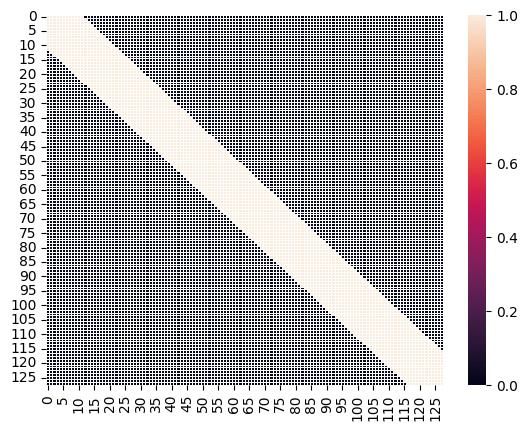

In [36]:
M_linear = create_mask_linear(X_train[0], X_train[10], 12)
draw_matrix(M_linear)
type(M_linear)

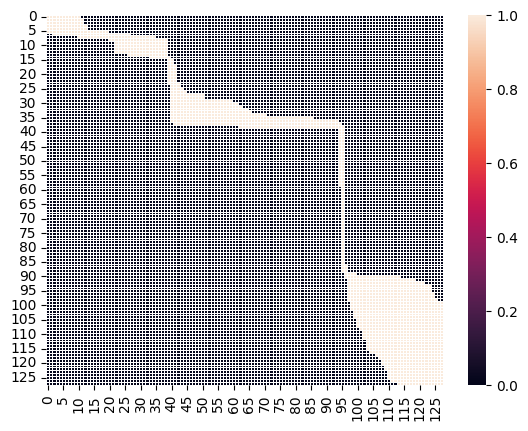

In [23]:
M_non_linear = create_mask_non_linear(X_train[0], X_train[10])
draw_matrix(M_non_linear)

### 2.2. Two dimensional data

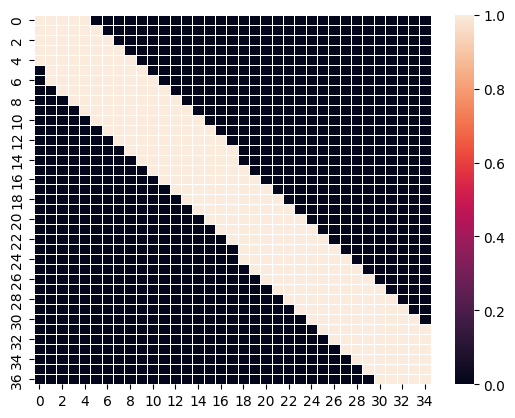

In [10]:
M_linear = create_mask_linear(X_train_arabic[0], X_train_arabic[760], 5)
draw_matrix(M_linear)

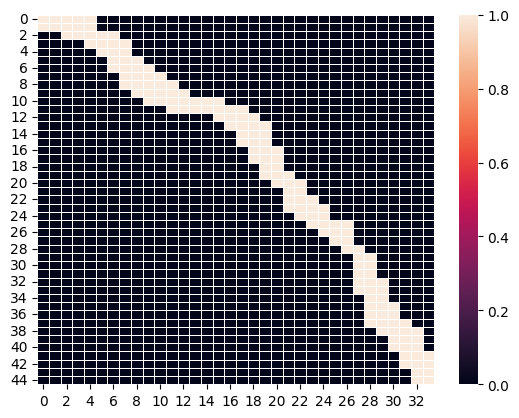

In [25]:
M_non_linear = create_mask_non_linear(X_train_arabic[2], X_test_arabic[395])
draw_matrix(M_non_linear)

## 3. Optimal matrix

In [27]:
from GetData.GetDataMultiDimensions import get_test_data, get_train_data
from GetData.GetDataOneDimension import getData
from MaskingMap.MaskingMapAutoWeighted import masking_map_auto_weighted
from MaskingMap.Utilities.utils import draw_matrix_aw
import os

X_train, y_train, X_test, y_test = getData('BME', '../Data/OneDimension/')
X_train_arabic, y_train_arabic = get_train_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Train_Arabic_Digit.txt'))
X_test_arabic, y_test_arabic = get_test_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Test_Arabic_Digit.txt'))

len(X_train), len(X_test), len(X_train_arabic), len(X_test_arabic)

(30, 150, 6600, 2200)

### 3.1. One dimensional data

(array([[0.00108503, 0.00099055, 0.00085114, ..., 0.        , 0.        ,
         0.        ],
        [0.00085026, 0.00079138, 0.00084663, ..., 0.        , 0.        ,
         0.        ],
        [0.00085632, 0.00079701, 0.00085266, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00045564, 0.00044318,
         0.00044258],
        [0.        , 0.        , 0.        , ..., 0.00047087, 0.00045799,
         0.00045738],
        [0.        , 0.        , 0.        , ..., 0.00054985, 0.00057373,
         0.00057296]]),
 0.41388397237297625,
 0.7621882224417316,
 2.9110046526226285,
 2,
 None)

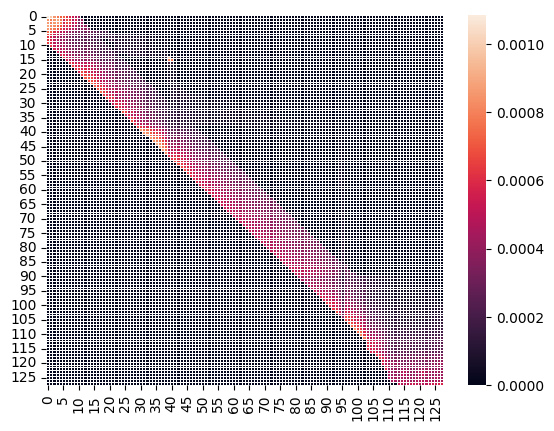

In [34]:
T, dis, w1, w2, iterations = masking_map_auto_weighted(X_train[0], X_train[10], lamb=10, ratio=0.1, algorithm="sinkhorn")
T, dis, w1, w2, iterations, draw_matrix_aw(T)

Iter: 1; w1: 0.5; w2: 0.5; M: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]; isTrue: (array([  0,   0,   0, ..., 127, 127, 127], dtype=int64), array([  5,   6,   7, ..., 120, 121, 122], dtype=int64)) 
Iter: 2; w1: 0.7550714058934919; w2: 3.667530439831481; M: [[4.42260185 4.42260185 4.42260185 ... 0.         0.         0.        ]
 [4.42260185 4.42260185 4.42260185 ... 0.         0.         0.        ]
 [4.42260185 4.42260185 4.42260185 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 4.42260185 4.42260185 4.42260185]
 [0.         0.         0.         ... 4.42260185 4.42260185 4.42260185]
 [0.         0.         0.         ... 4.42260185 4.42260185 4.42260185]]; isTrue: (array([], dtype=int64), array([], dtype=int64)) 


(array([[0.00147627, 0.00145794, 0.0010694 , ..., 0.        , 0.        ,
         0.        ],
        [0.00121341, 0.00122174, 0.00111575, ..., 0.        , 0.        ,
         0.        ],
        [0.00122104, 0.00122943, 0.00112277, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00044453, 0.00043068,
         0.00043   ],
        [0.        , 0.        , 0.        , ..., 0.00045978, 0.00044546,
         0.00044475],
        [0.        , 0.        , 0.        , ..., 0.00053841, 0.0005596 ,
         0.00055872]]),
 0.39926027384239005,
 0.7550714058934919,
 3.667530439831481,
 2,
 None)

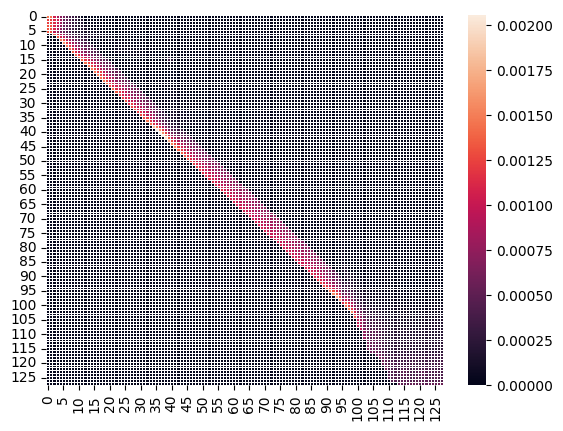

In [60]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_train[10], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations, draw_matrix(T)

Iter 1: 1.3243780551015292; w1: 0.7550714058934919; w2: 3.667530439831481
Iter 2: 1.3243780551015292; w1: 0.7550714058934919; w2: 3.667530439831481


(array([[0.00147627, 0.00145794, 0.0010694 , ..., 0.        , 0.        ,
         0.        ],
        [0.00121341, 0.00122174, 0.00111575, ..., 0.        , 0.        ,
         0.        ],
        [0.00122104, 0.00122943, 0.00112277, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00044453, 0.00043068,
         0.00043   ],
        [0.        , 0.        , 0.        , ..., 0.00045978, 0.00044546,
         0.00044475],
        [0.        , 0.        , 0.        , ..., 0.00053841, 0.0005596 ,
         0.00055872]]),
 0.39926027384239005,
 0.7550714058934919,
 3.667530439831481,
 2,
 None)

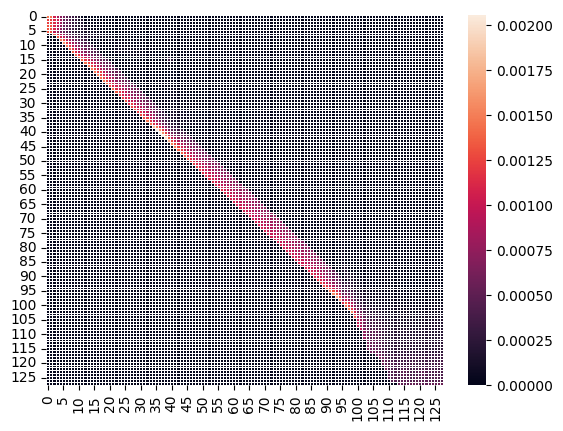

In [45]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_train[10], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations, draw_matrix(T)

Iter 1: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437
Iter 2: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437


(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2,
 None)

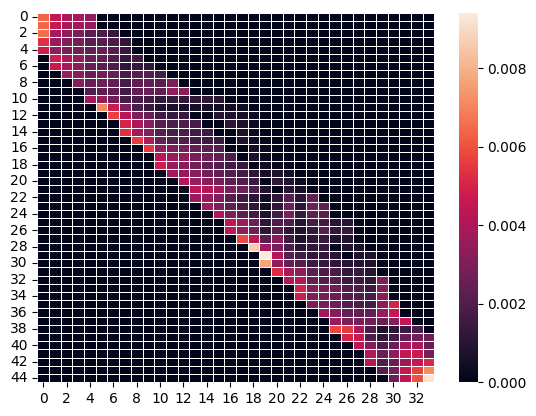

In [46]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations, draw_matrix(T)

### 3.2. Two dimensional data

Iter 1: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437
Iter 2: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437


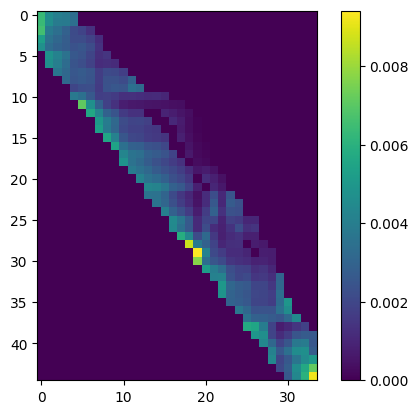

(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2,
 None)

In [49]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1, algorithm="sinkhorn")
T, dis, w1, w2, iterations, draw_matrix_aw(T, type="matplotlib")

In [42]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations

(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2)

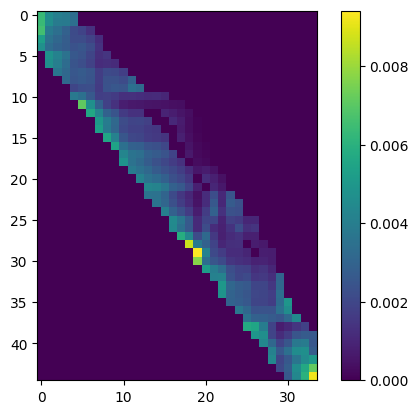

In [43]:
draw_matrix(T, type="matplotlib")

In [56]:
1/2

0.5